In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
%load_ext line_profiler
%load_ext memory_profiler

## Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

In [10]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

# Multi-factor matrix factorization

## Small example

In [9]:
# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

In [10]:
# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')

In [11]:
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 
# array([[   nan,    nan, 192.14],
#        [   nan, 285.38, 292.98],
#        [226.07, 229.06,    nan],
#        [222.13, 248.42,    nan]])

### Naive implementation of gradient descent (loop gradient descent over each factor)

In [18]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

pd.DataFrame(skater_scores, index=skater_names).to_csv('viz/skater_scores.csv') # Save for Google sheets
pd.DataFrame(event_scores, columns=event_names).to_csv('viz/event_scores.csv') # Save for Google sheets

baseline, skater_scores, event_scores

(0.3745401188473625, array([[0.95071431, 0.73199394],
        [0.59865848, 0.15601864],
        [0.15599452, 0.05808361],
        [0.86617615, 0.60111501]]), array([[0.70807258, 0.02058449, 0.96990985],
        [0.83244264, 0.21233911, 0.18182497]]))

In [19]:
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores
np.save('viz/residuals', residuals)

In [20]:
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2197476297753707

In [21]:
alpha = 0.0005
for k in range(n_factors):
    skater_scores_k = skater_scores[:, [k]]
    event_scores_k = event_scores[[k], :]

    event_gradients = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
    skater_gradients = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)    

    event_scores[[k], :] = event_scores_k - alpha * event_gradients
    skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients
    
event_scores, skater_scores

(array([[0.82122113, 0.23107951, 1.14796841],
        [0.90530817, 0.31571784, 0.27440279]]),
 array([[1.04320019, 0.74933189],
        [0.74319648, 0.21281884],
        [0.23819621, 0.17623456],
        [0.94684278, 0.71927024]]))

### Broadcasted implementation of gradient descent

In [22]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

event_scores, skater_scores

(array([[0.70807258, 0.02058449, 0.96990985],
        [0.83244264, 0.21233911, 0.18182497]]),
 array([[0.95071431, 0.73199394],
        [0.59865848, 0.15601864],
        [0.15599452, 0.05808361],
        [0.86617615, 0.60111501]]))

In [23]:
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores

In [24]:
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2197476297753707

In [25]:
event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)

event_scores = event_scores - alpha * event_gradients
skater_scores = skater_scores - alpha * skater_gradients

event_scores, skater_scores

(array([[0.82122113, 0.23107951, 1.14796841],
        [0.90530817, 0.31571784, 0.27440279]]),
 array([[1.04320019, 0.74933189],
        [0.74319648, 0.21281884],
        [0.23819621, 0.17623456],
        [0.94684278, 0.71927024]]))

## Profiling two methods in comparison

### Time profiling

In [26]:
def naive_gradient_descent(residuals, n_factors):
    random_state = np.random.RandomState(seed=42)
    event_scores = random_state.random_sample((n_factors, residuals.shape[1]))
    skater_scores = random_state.random_sample((residuals.shape[0], n_factors))
    
    alpha = 0.0005       
    for k in range(n_factors):
        event_scores_k = event_scores[[k], :]
        skater_scores_k = skater_scores[:, [k]]
        
        event_gradients = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
        skater_gradients = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)    
                
        event_scores[[k], :] = event_scores_k - alpha * event_gradients
        skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients
    
    return baseline, event_scores, skater_scores

In [27]:
def broadcast_gradient_descent(residuals, n_factors):    
    random_state = np.random.RandomState(seed=42)
    event_scores = random_state.random_sample((n_factors, residuals.shape[1]))
    skater_scores = random_state.random_sample((residuals.shape[0], n_factors))
    
    alpha = 0.0005
    
    event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
    skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)
    
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    
    return baseline, event_scores, skater_scores

In [441]:
naive_times = []
broadcast_times = []
n_factor_values = 10**np.arange(6)

for k in n_factor_values:
    print(f'Factors: {k}')
    print('Naive: ', end='')
    naive_runtimes = %timeit -o naive_gradient_descent(residuals, k)
    print('Broadcast: ', end='')
    broadcast_runtimes = %timeit -o broadcast_gradient_descent(residuals, k)
    
    naive_times.append(np.mean(naive_runtimes.all_runs)*1e6 / naive_runtimes.loops)
    broadcast_times.append(np.mean(broadcast_runtimes.all_runs)*1e6 / broadcast_runtimes.loops)

Factors: 1
Naive: 93.8 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Broadcast: 65.7 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 10
Naive: 737 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Broadcast: 74.1 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 100
Naive: 7.21 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Broadcast: 148 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 1000
Naive: 72.1 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Broadcast: 745 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Factors: 10000
Naive: 714 ms ± 91.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast: 6.49 ms ± 869 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Factors: 100000
Naive: 9.16 s ± 1.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast: 66.6 ms ± 1.27 ms per loop

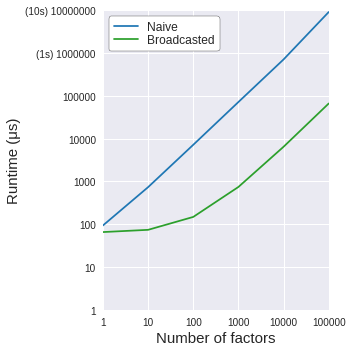

In [471]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_factor_values, naive_times, color='tab:blue', label='Naive')
ax.plot(n_factor_values, broadcast_times, color='tab:green', label='Broadcasted')
ax.set_xscale('log')
ax.set_xticks(n_factor_values)
ax.set_xticklabels(n_factor_values)
ax.set_xlim(1, n_factor_values[-1])
ax.set_xlabel('Number of factors', fontsize=15)

ax.set_yscale('log')
ax.set_yticks(10**np.arange(8))
ax.set_yticklabels(list(10**np.arange(6)) + ['(1s) 1000000', '(10s) 10000000'])
ax.set_ylim(1, 1e7)
ax.set_ylabel('Runtime (μs)', fontsize=15)

ax.legend(**legend_opts)

plt.tight_layout()
plt.show()

# Batch GD using multi factor

### Toy example

In [28]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

pd.DataFrame(skater_scores, index=skater_names).to_csv('viz/skater_scores.csv') # Save for Google sheets
pd.DataFrame(event_scores, columns=event_names).to_csv('viz/event_scores.csv') # Save for Google sheets

# baseline, skater_scores, event_scores

In [29]:
alpha = 0.0005
for i in range(1000):
    # 2a. Calculate gradients
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    baseline_gradient = np.nansum(residuals)
    event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
    skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)
    
    # 2b. Update latent scores using gradients
    baseline = baseline - alpha * baseline_gradient
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    
    if i in [998, 999]:
        print(i, np.sqrt(np.nanmean(residuals**2)))

998 0.002070682021509688
999 0.002047425469550496


In [30]:
pd.DataFrame(skater_scores, index=skater_names).sort_values(by=0, ascending=False)

,0,1
"Javier, FERNANDEZ",14.764506,7.613596
"Takahito, MURA",12.546155,6.994526
"Alexander, MAJOROV",9.653103,4.485617
"Misha, GE",9.353478,10.411243


### Male skaters in 2017 season

In [11]:
def batch_gd_multi(season_scores, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000, n_factors = 1,
             log_iter=False, log_every=10, additional_iter=range(1, 10),
             return_rmse=False):
    '''
    Run gradient descent on some season scores table (long format)
    Return skater and event scores (along with final RMSE and other intermediate values if needed)'''
    
    # Convert long table to pivot table
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    # Modify skater position in pivot table (for aesthetic value only)
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    # Store skater and event names to retrieve later
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    
    # Convert pivot table to numpy array
    true_scores = season_pivot.values

    # Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
    random_state = np.random.RandomState(init_seed)
    skater_scores = random_state.random_sample((len(skater_names), n_factors))
    event_scores = random_state.random_sample((n_factors, len(event_names)))
    baseline = random_state.random_sample()
    
    # Different lists to contain intermediate values if logging is enabled
    skater_scores_log = []
    event_scores_log = []
    baseline_log = []
    rmse_log = []
    residual_log = []
    iter_log = []
    
    # Run gradient descent
    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
        
        # Log intermediate values at certain iterations if logging is enabled
        if log_iter and (i%log_every==0 or (i in additional_iter)):            
            iter_log.append(i)
            skater_scores_log.append(pd.DataFrame(skater_scores, index=skater_names))
            event_scores_log.append(pd.DataFrame(event_scores.T, index=event_names))
            baseline_log.append(baseline)
            residual_log.append(residuals)
            rmse = np.sqrt(np.nanmean(residuals**2))
            rmse_log.append(rmse)
        
        # Calculate parameter gradients
        baseline_gradient = np.nansum(residuals)
        event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
        skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)
        
        # Update parameters
        baseline = baseline - alpha * baseline_gradient
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients        
        
        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    
    # Collect logs together in one list
    log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log]
    
    # Put event and skater scores back into Series form with names added
    skater_scores = pd.DataFrame(skater_scores, index=skater_names)
    event_scores = pd.DataFrame(event_scores.T, index=event_names)
    
    if log_iter:
        return baseline, event_scores, skater_scores, log
    elif return_rmse:
        return baseline, event_scores, skater_scores, rmse_new
    else:
        return baseline, event_scores, skater_scores

In [12]:
example_skater_order = np.load('viz/example_skater_order.npy')
baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log] = batch_gd_multi(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=151, n_factors=5,
log_iter=True, log_every=5, additional_iter=list(range(16)) + list(range(10, 51, 5)))

Alpha: 0.0005, Iter: 151, Last RMSE: 2.6, Delta RMSE: -0.025845557


In [13]:
_, _, _, rmse_1 = batch_gd_multi(season_scores, skater_order=None, init_seed=42, alpha=0.0005, n_iter=151, n_factors = 1, return_rmse=True)

Alpha: 0.0005, Iter: 151, Last RMSE: 8.86, Delta RMSE: -1.76e-08


In [14]:
def update(i, fig, ax, axr, verbose=False):
    if verbose:
        print(i)
    
    fig.suptitle(f'Iteration {iter_log[i]}\nα = 0.0005', x=0.3, y=0.95, va='bottom', ha='center', fontsize=20)
    residuals = residual_log[i]
    ax.imshow(-residuals, cmap='coolwarm', vmin=-30, vmax=30, aspect='auto') # Neagtive residual: red, positive: blue
    ax.set_yticklabels(skater_scores_log[i].applymap('{:.2f}'.format).apply(lambda x: '  '.join(x), axis=1))
    ax.set_xticklabels(event_scores_log[i].applymap('{:.2f}'.format).apply(lambda x: '\n'.join(x), axis=1),
                       fontsize=10) 
    baseline_text.set_text('{0:.2f}'.format(baseline_log[i]))
    
    if i == 0:
        axr.plot(iter_log[i], rmse_log[i], '.', color='tab:brown', clip_on=False)
    if i >= 1:
        axr.plot(iter_log[i-1:i+1], rmse_log[i-1:i+1], '.-', color='tab:brown', clip_on=False)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
0


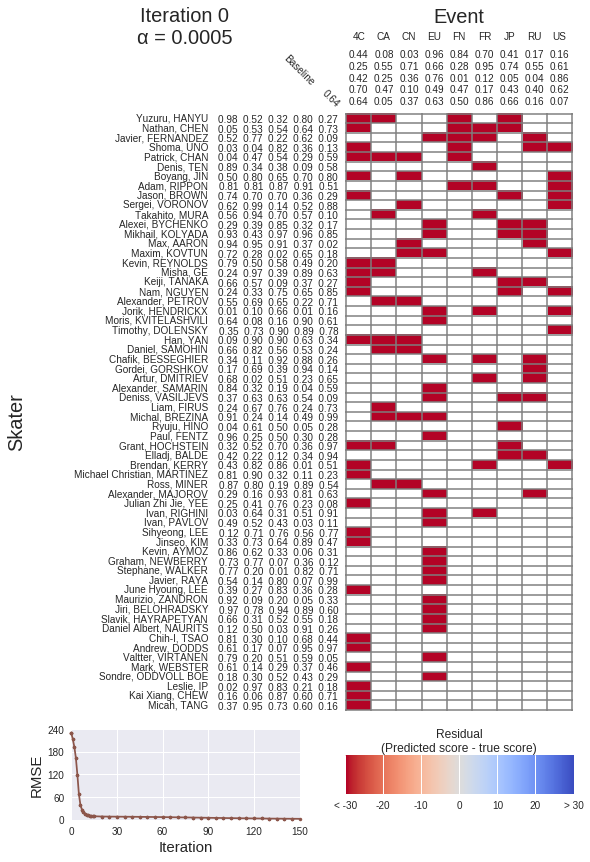

In [18]:
# Set up figure grid
fig = plt.figure(figsize=(9, 13))
grid = plt.GridSpec(20, 2, hspace=1)

# Set up heat map of residuals
ax = fig.add_subplot(grid[:-3, 1])
ax.set_xticks(np.arange(-.5, len(event_names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(skater_names), 1), minor=True)
ax.grid(which='minor', color='tab:gray', ls='-', lw=1.5)
ax.grid(None, which='major')
ax.set_xlim(-0.54, len(event_names)-0.45)
ax.set_xticks(range(len(event_names)))
ax.xaxis.tick_top()
ax.set_ylim(-0.6, len(skater_names)-0.45)
ax.set_yticks(range(len(skater_names)))
ax.set_facecolor('white')


for i, skater in enumerate(skater_names):
    ax.text(x=-6, y=i-0.3, s=skater, ha='right')
for i, event in enumerate(event_names):
    ax.text(x=i, y=len(skater_names)+7, s=event, va='bottom', ha='center')
ax.text(x=-1.7, y=len(skater_names)+2.3, s='Baseline', rotation=-45, va='bottom', ha='right')
baseline_text = ax.text(x=-0.7, y=len(skater_names), s='', rotation=-45, va='bottom', ha='right')

ax.text(x=-14, y=len(skater_names)/2, s='Skater', rotation=90, fontsize=20)
ax.text(x=4, y=len(skater_names)+9, s='Event', fontsize=20, ha='center')

# Set up RMSE plot
axr = fig.add_subplot(grid[-3:, 0])
axr.set_xlim(0, iter_log[-1])
axr.set_xticks(range(0, iter_log[-1]+1, 30))
axr.set_xlabel('Iteration', fontsize=15)
axr.set_ylim(0, 240)
axr.set_yticks(np.arange(0, 241, 60))
axr.set_ylabel('RMSE', fontsize=15)

# Plot colorbar of residual
axc = fig.add_subplot(grid[-3:, 1])
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.arange(cmap.N, -1, -1)) # Plot colorbar from red to blue (not blue to red)
axc.imshow([colors], extent=[-30, 30, 0, 10])
axc.xaxis.set_label_position('top') 
axc.set_xlabel('Residual\n(Predicted score - true score)', fontsize=12)
axc.set_xticklabels(['< -30', '-20', '-10', '0', '10', '20', '> 30'])
axc.set_yticks([])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax, axr, verbose=True), 
                     frames=len(iter_log), interval=500)

anim.save('viz/batch_anim_multi.gif', writer='imagemagick')